Load the big data file es_forecast.csv via vaex in memory-friendly chunks into several HDF5 files and store those in the directory data/es_forecast:

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, vaex
from tqdm.notebook import tqdm

import datetime

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Read in the first two lines of data and store the data types
# in a dictionary. 
df_first2 = vaex.from_csv('data/es_forecast.csv', nrows = 30)
column_types = {name: (str(dtype.__name__) if isinstance(dtype, type) else 'float64') for name,dtype in df_first2.dtypes.to_dict().items()}

# Create a new directory in the data folder that holds the 
# converted data chunks for further preprocessing.
!mkdir data/es_forecast

# Read in the data in memory-friendly chunks.
# Export the data in the data format 'HDF5'.
for i, df in tqdm(enumerate(vaex.from_csv('data/es_forecast.csv', chunk_size=200_000, dtype=column_types)), total=185):
    df.export_hdf5(f'data/es_forecast/es_forecast_{i:02}.hdf5')
    
# Count the files exported.
print( f"# HDF5 Files in data/es_forecast: {len(os.listdir('data/es_forecast/'))}")

  0%|          | 0/185 [00:00<?, ?it/s]

# HDF5 Files in data/es_forecast: 185


Check the folder size in data/es_forecast:

In [114]:
# Check the folder size.
!du -h data/es_forecast

du: data/es_forecast: No such file or directory


In [45]:
# Import all .hdf5 chunks into a single dataset and
# export it to a single .hdf5 file we can work on
df = vaex.open('data/es_forecast/es_forecast*')
df.export_hdf5('data/es_forecast_aggregated.hdf5')

# Remove the temporary file directory from the data 
# preprocessing step.
!rm -r data/es_forecast


"\n# Import all .hdf5 chunks into a single dataset and\n# export it to a single .hdf5 file we can work on\ndf = vaex.open('data/es_forecast/es_forecast*')\ndf.export_hdf5('data/es_forecast_aggregated.hdf5')\n\n# Remove the temporary file directory from the data \n# preprocessing step.\n!rm -r data/es_forecast\n"

In [2]:
# Open the HDF5 file and show the dimensions
df = vaex.open('data/es_forecast_aggregated.hdf5')
print(f'Data dimensions: {df.shape}')

Data dimensions: (36876431, 6)


In [5]:
# Show some summary statistics
df.describe()

,dt_start_utc,power_mw,carrier,type,area,version_utc
dtype,str,float64,str,str,str,str
count,36876431,36876431,36876431,36876431,36876431,36876431
NA,0,0,0,0,0,0
mean,--,8283.930682527276,--,--,--,--
std,--,14112.233684,--,--,--,--
min,--,0.0,--,--,--,--
max,--,76393.0,--,--,--,--


# How to filter via utc timestamps in the hdf5 dataframe

In order to filter via dates in the vaex df, you have to convert the information in the 'dt_start_utc' column to 'datetime64' and the define a filter variable (here: start_date) according to below code. At the beginning of the notebook you can see the necessary imports (import datetime to use the below code).

In [4]:
df['dt_start_utc']=df.dt_start_utc.astype('datetime64')

In [5]:
start_date=np.datetime64('2019-01-01')
df_date_filter2=df[(df.dt_start_utc >= start_date)]

In [31]:
df_date_filter2.describe()

,dt_start_utc,power_mw,carrier,type,area,version_utc
dtype,datetime64[s],float64,str,str,str,str
count,35675945,35675945,35675945,35675945,35675945,35675945
NA,0,0,0,0,0,0
mean,2020-08-08T16:54:57,8319.494562708851,--,--,--,--
std,16888453.056214,14128.323035,--,--,--,--
min,2019-01-01T00:00:00,0.0,--,--,--,--
max,2021-07-14T21:45:36,75411.0,--,--,--,--


## Below code doesn´t work!

In [ ]:
df_date_filter2.sort_values(by="dt_start_utc")

## Below Code should work! Here it gets interesting

In [23]:
#df_1= pd.read_csv("data/data_processed/es_fc_wind_offshore_ts.csv")

In [24]:
#df_1['dt_start_utc']=df_1['dt_start_utc'].astype('datetime64')

In [25]:
#df_2 = pd.read_csv("data/data_processed/es_fc_wind_onshore_ts.csv")

In [26]:
#df_2['dt_start_utc']=df_2['dt_start_utc'].astype('datetime64')

In [2]:
df_3 = pd.read_csv("data/data_processed/imbalance_de_labeled.csv")

In [3]:
df_3['dt_start_utc']=df_3['dt_start_utc'].astype('datetime64')

In [4]:
from apymb import *
df_input = align(df_3)

In [5]:
df_input_nan = df_input.copy()

In [6]:
df_input.describe()

,1_power_mw,1_rebap_eur_mwh
count,257010.000000,257010.000000
mean,80.643117,34.069293
std,494.250861,127.651278
min,-4111.964000,-6503.730000
25%,-205.708750,5.280000
50%,76.400000,38.080000
75%,365.362750,60.940000
max,3866.284000,24455.050000


Eliminate the "power_mw" column (which was part of the "df_3", which in itself came from 

In [7]:
df_input.drop(["1_power_mw"], axis=1, inplace=True)

In [8]:
df_input.isna().sum()

1_rebap_eur_mwh    0
dtype: int64

In [9]:
df_input.describe()

,1_rebap_eur_mwh
count,257010.000000
mean,34.069293
std,127.651278
min,-6503.730000
25%,5.280000
50%,38.080000
75%,60.940000
max,24455.050000


Run a small analysis on the created combined csv (es_fc_wind_onshore_ts.csv,es_fc_wind_offshore_ts.csv + imbalance_de_labeled.csv) named "df_input"

In [10]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

In [11]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [12]:
df_input.describe()

,1_rebap_eur_mwh
count,257010.000000
mean,34.069293
std,127.651278
min,-6503.730000
25%,5.280000
50%,38.080000
75%,60.940000
max,24455.050000


# Visualize the Data:

I start by plotting the rebap prize in €/mwh data over time. I can either use the hourly development or aggregate the feature by day to get a less dense plot. 

In [15]:
df_input = pd.read_csv("data/data_processed/df_rebap.csv")

In [16]:
df_input['timestamp']=df_input['timestamp'].astype('datetime64')

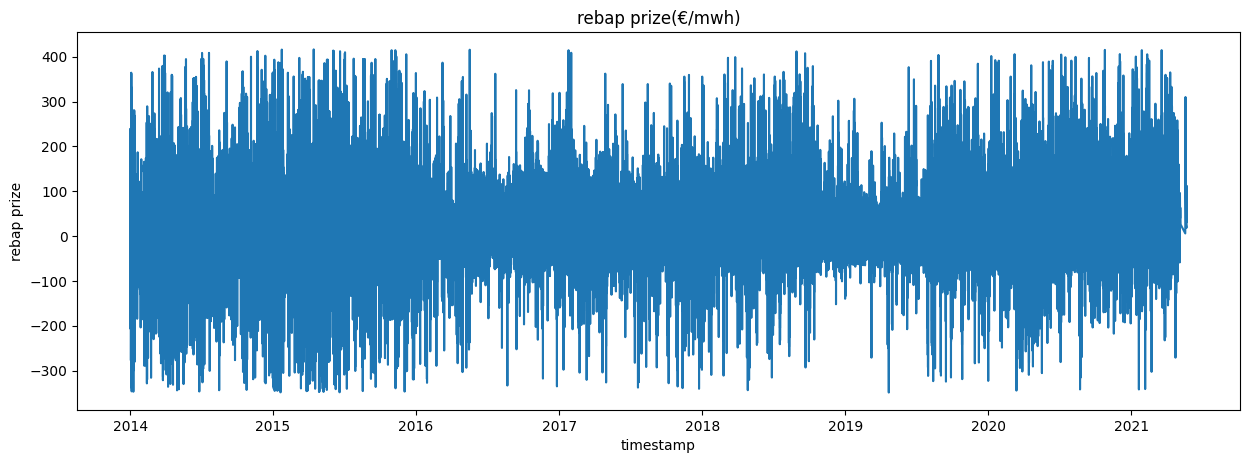

In [17]:
# Temperature hourly development over time 
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='1_rebap_eur_mwh', data=df_input, ax=ax)
ax.set(title='rebap prize(€/mwh)', ylabel='rebap prize');

As we can see we have some hefty outliers concerning the rebap prize. Let´s take a look at the Box Plot for the rebap_eur_mwh colun: 

<AxesSubplot:xlabel='1_rebap_eur_mwh'>

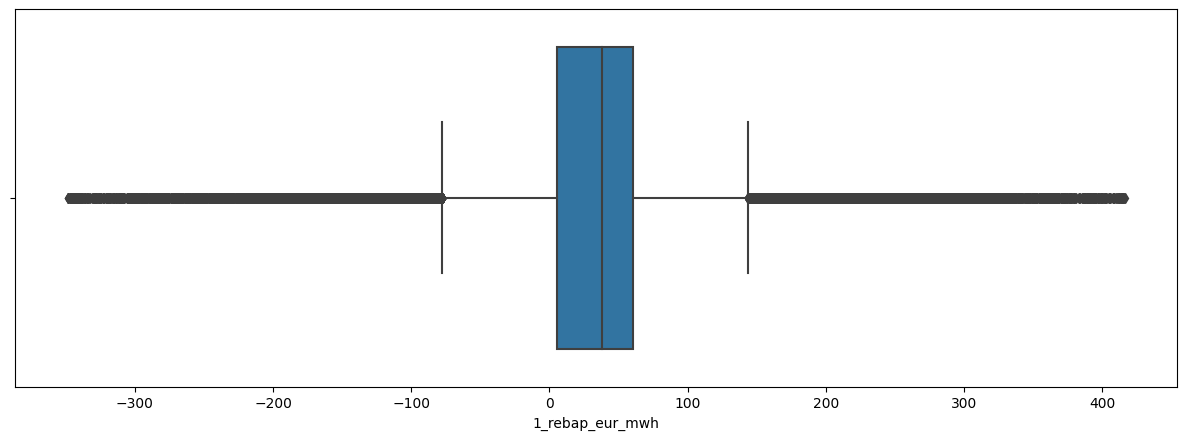

In [18]:
sns.boxplot(x=df_input['1_rebap_eur_mwh'])

## Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those outliers outside the +/- 3 Standard Deviation range with the following code line:

In [19]:
std_dev = 3*df_input['1_rebap_eur_mwh'].std()
df_input = df_input[np.abs(df_input['1_rebap_eur_mwh'] - df_input['1_rebap_eur_mwh'].mean()) <= std_dev]

In [20]:
df_input.to_csv("data/data_processed/df_rebap.csv", index=True)

Check the boxplot again:

<AxesSubplot:xlabel='1_rebap_eur_mwh'>

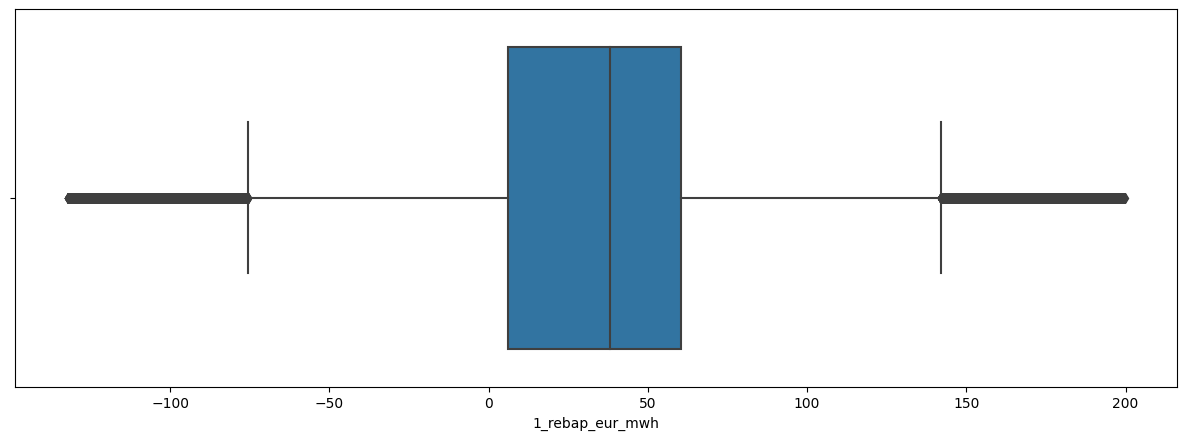

In [21]:
sns.boxplot(x=df_input['1_rebap_eur_mwh'])

In [22]:
df_input['1_rebap_eur_mwh'].describe()

count    251193.000000
mean         33.828497
std          45.709334
min        -132.140000
25%           5.970000
50%          38.090000
75%          60.380000
max         199.680000
Name: 1_rebap_eur_mwh, dtype: float64

## Visualize again the rebap prizes after the capping of the extreme values:

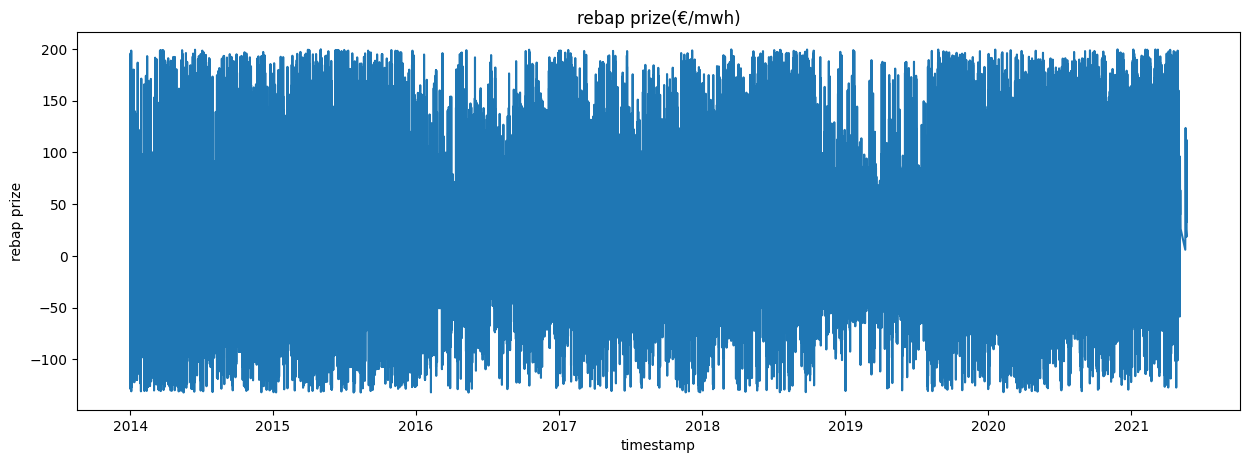

In [23]:
# Temperature hourly development over time 
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='1_rebap_eur_mwh', data=df_input, ax=ax)
ax.set(title='rebap prize(€/mwh)', ylabel='rebap prize');

In [24]:
df_input.isna().sum()

timestamp          0
1_rebap_eur_mwh    0
dtype: int64

Check decomposition of trend, seasonality and residue of original time series:

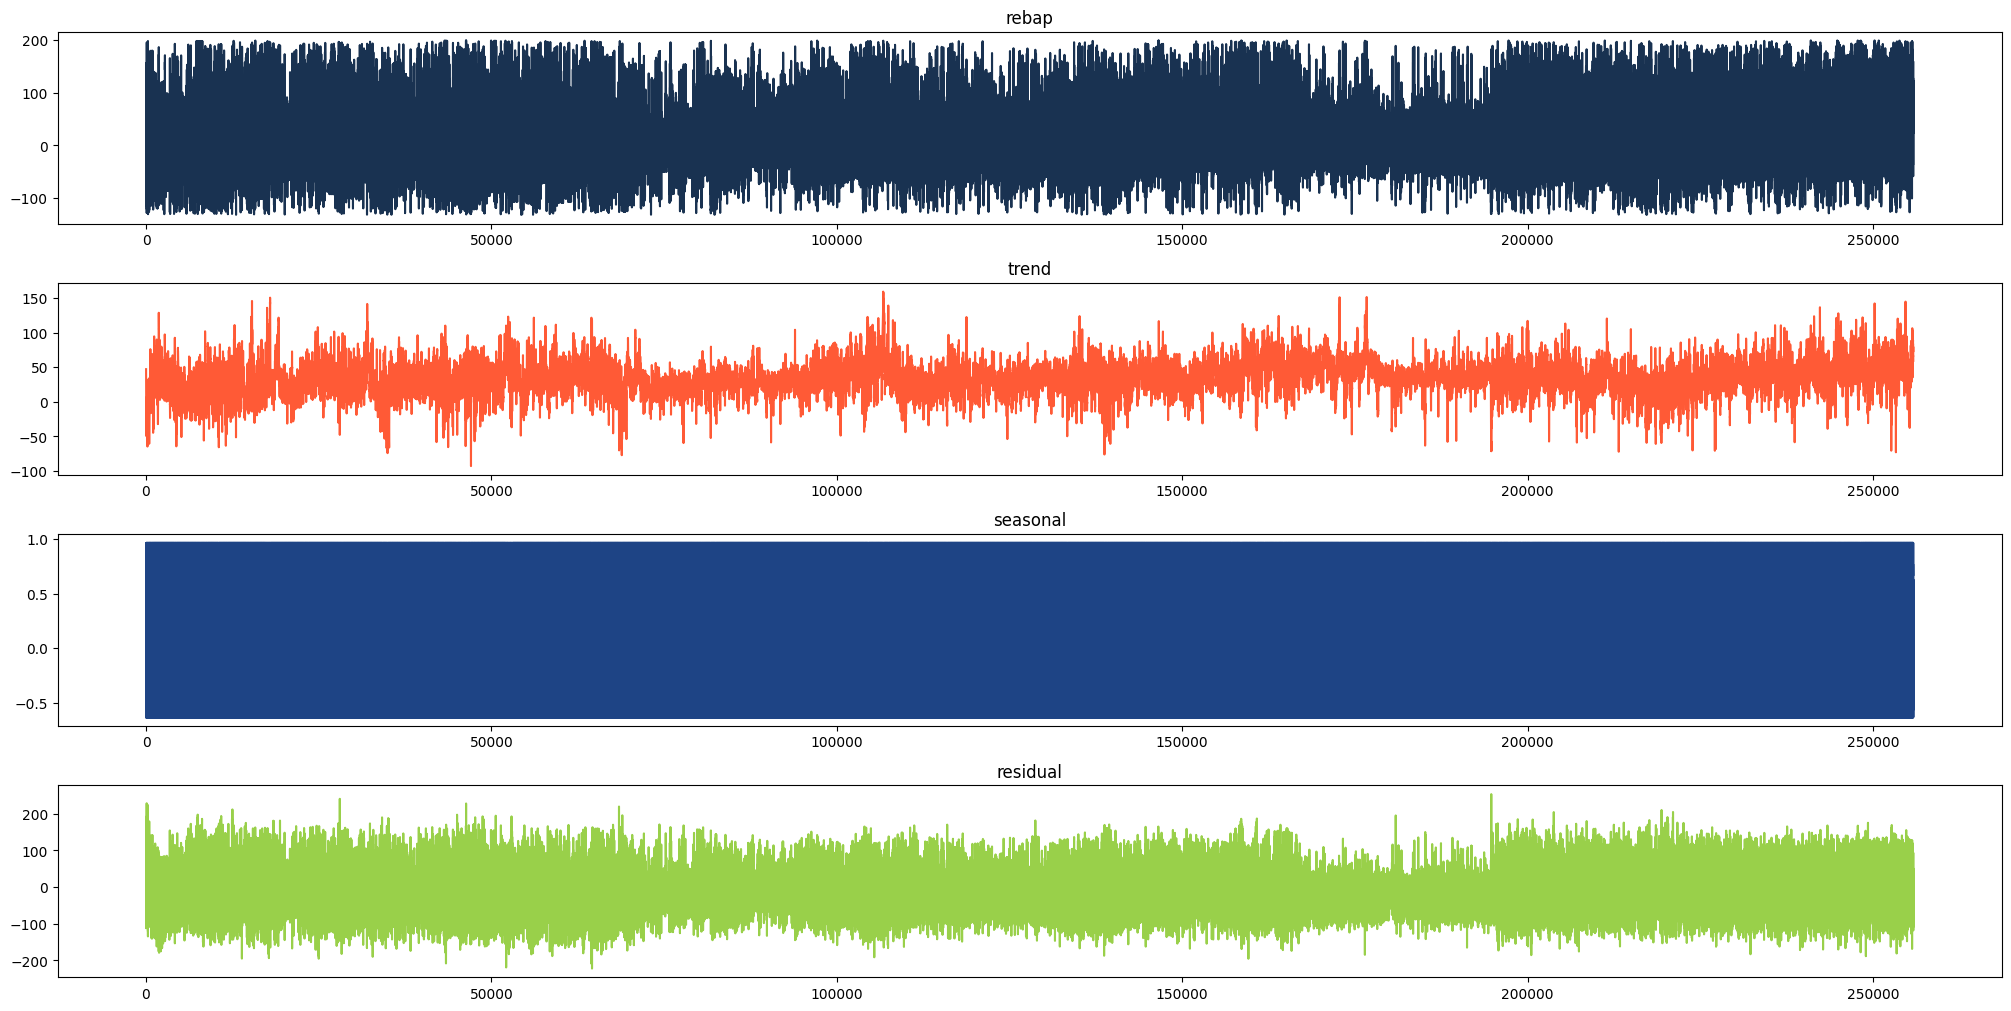

In [25]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df_input['1_rebap_eur_mwh'], 
                                   model='additive',
                                   period=24)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='rebap')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [26]:
def plot_ts(ts = None, ts_add = None, title ='Time Series', legend=['1']):
    """
    Plots one or two time series in a single plot
    
        Args:
        ts: 1d- or 2d-array of time series. Dimension
            must be (n,) or (n,2)
        title: Title for the time plot.
        legend: list of legend names. If empty no legend.
        
        Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(10, 4))
    plt.plot(ts[:,], color=NF_ORANGE)
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color=NF_BLUE)
    if len(legend) > 0:
        plt.legend(legend)
    plt.show()

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -31.191784
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 10.419534
p-value: 0.010000
----------------------------------------


/Users/borisgeller/Desktop/Capstone-Project_DS/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


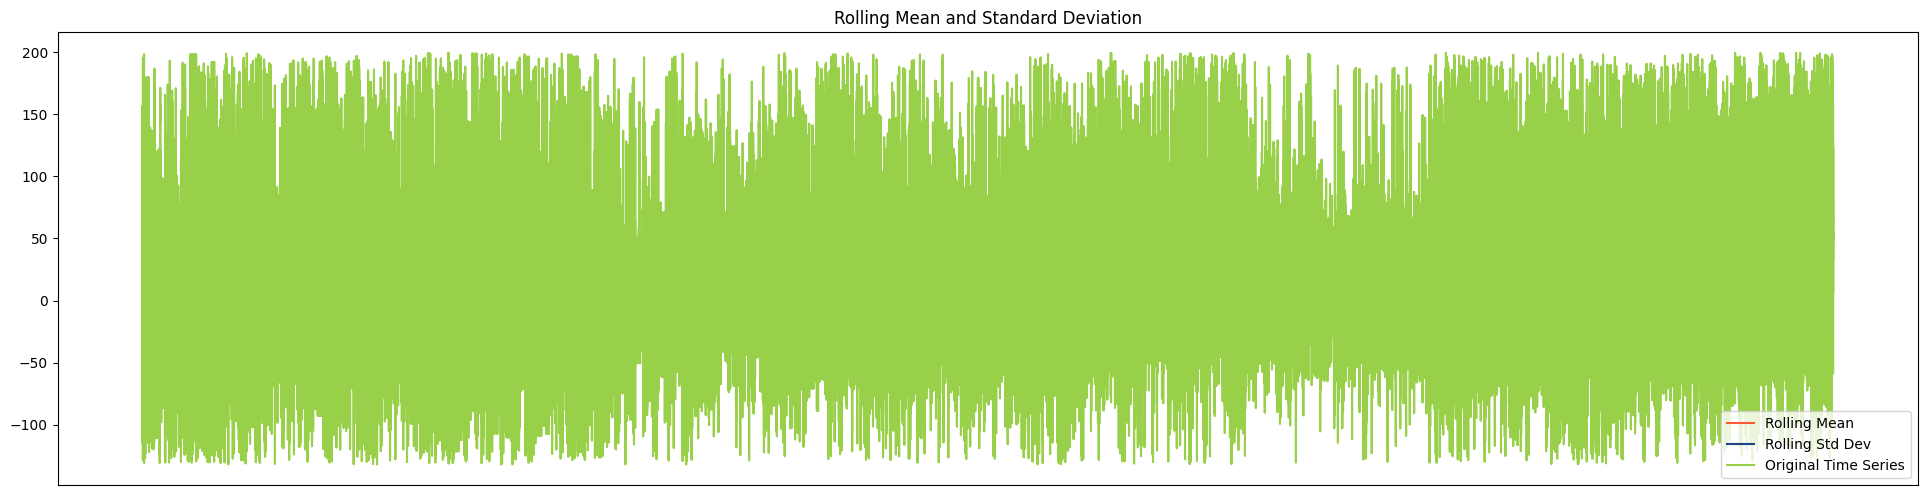

In [27]:
# Test for stationarity 

def stationarity_test(rebap_eur_mwh):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = rebap_eur_mwh.rolling(30).mean()
    rolling_std_dev = rebap_eur_mwh.rolling(24).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(rebap_eur_mwh, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(rebap_eur_mwh,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(rebap_eur_mwh, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_input['1_rebap_eur_mwh'])

The rolling mean moves up and down over time as the price of the stock varies. The p-value of the ADF test is 0 which tells us that we can confirm the null-hypothesis that the time series is non-stationary. On the other hand the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis. The tests are incoherent, but it is still possible that this time series is not stationary.

In [28]:
df_input.head()

,timestamp,1_rebap_eur_mwh
0,2013-12-31 23:00:00,156.36
1,2013-12-31 23:15:00,81.23
2,2013-12-31 23:30:00,104.01
3,2013-12-31 23:45:00,60.51
5,2014-01-01 00:15:00,89.82


In [29]:
df_input_nan = df_input.copy()

In [30]:
df_input = df_input_nan.copy()

# Attention!

If you shift your dataframe, beware of NaN rows! You will have to remove the first n lines if yu shift BY n lines! Otherwise you will still have NaNs and some algorithms won`t work!

In [31]:
def diff_series(ts, interval=1):
    """
    Differences a time series by a certain lag.
    
        Args:
        ts: array of 1d time series
        
        Returns:
        Differenced time series
    """
    diff = ts[interval:] - ts[:-interval]
    return diff

In [32]:
type(df_input['1_rebap_eur_mwh'])

pandas.core.series.Series

In [33]:
y = np.array(df_input['1_rebap_eur_mwh'].values.tolist())

In [34]:
type(y)

numpy.ndarray

In [35]:
# De-trending the time series
y_diff = diff_series(y)
#y_diff = y

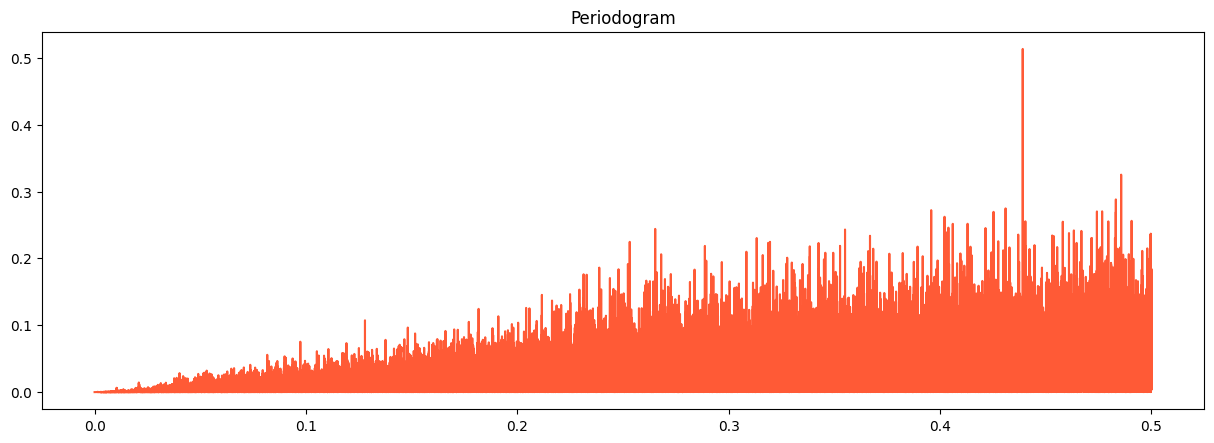

In [36]:
from scipy import signal

NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'

# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(y_diff, fs = 1, window='hamming', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show();

In [37]:
# De-trending the time series a second time
y_diff2 = diff_series(y_diff)

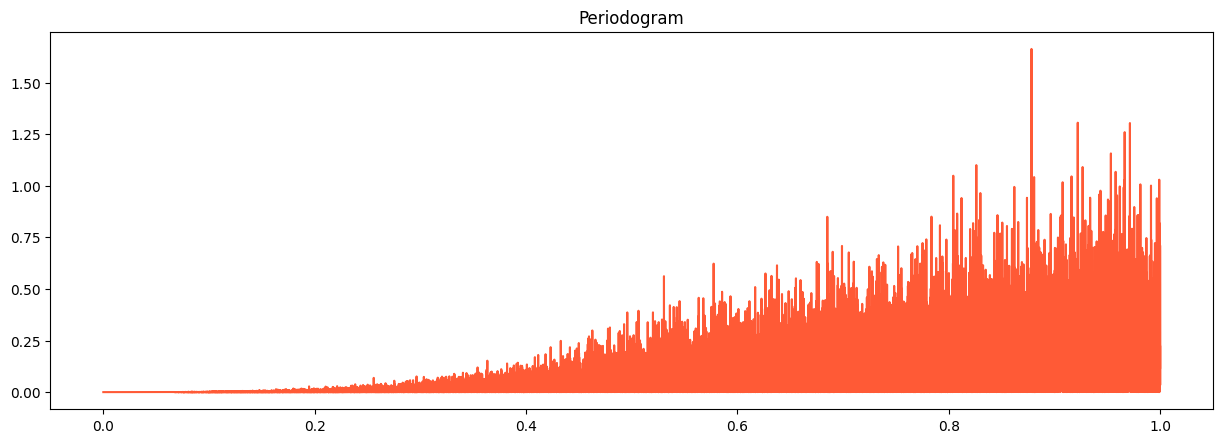

In [38]:
from scipy import signal

NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'

# We use for the sampling frequency 2 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(y_diff2, fs = 2, window='hamming', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show();

In [106]:
df_input = pd.read_csv("data/data_processed/df_rebap.csv")

In [39]:

# De-trending the time series
df_input['1_rebap_eur_mwh'] = (df_input['1_rebap_eur_mwh'] - df_input['1_rebap_eur_mwh'].shift(96))


In [40]:
df_input = df_input.dropna()


In [41]:
df_input.isna().sum()

timestamp          0
1_rebap_eur_mwh    0
dtype: int64

# If first Difference is not precise, use a second difference!

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -50.074653
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.001225
p-value: 0.100000
----------------------------------------


/Users/borisgeller/Desktop/Capstone-Project_DS/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


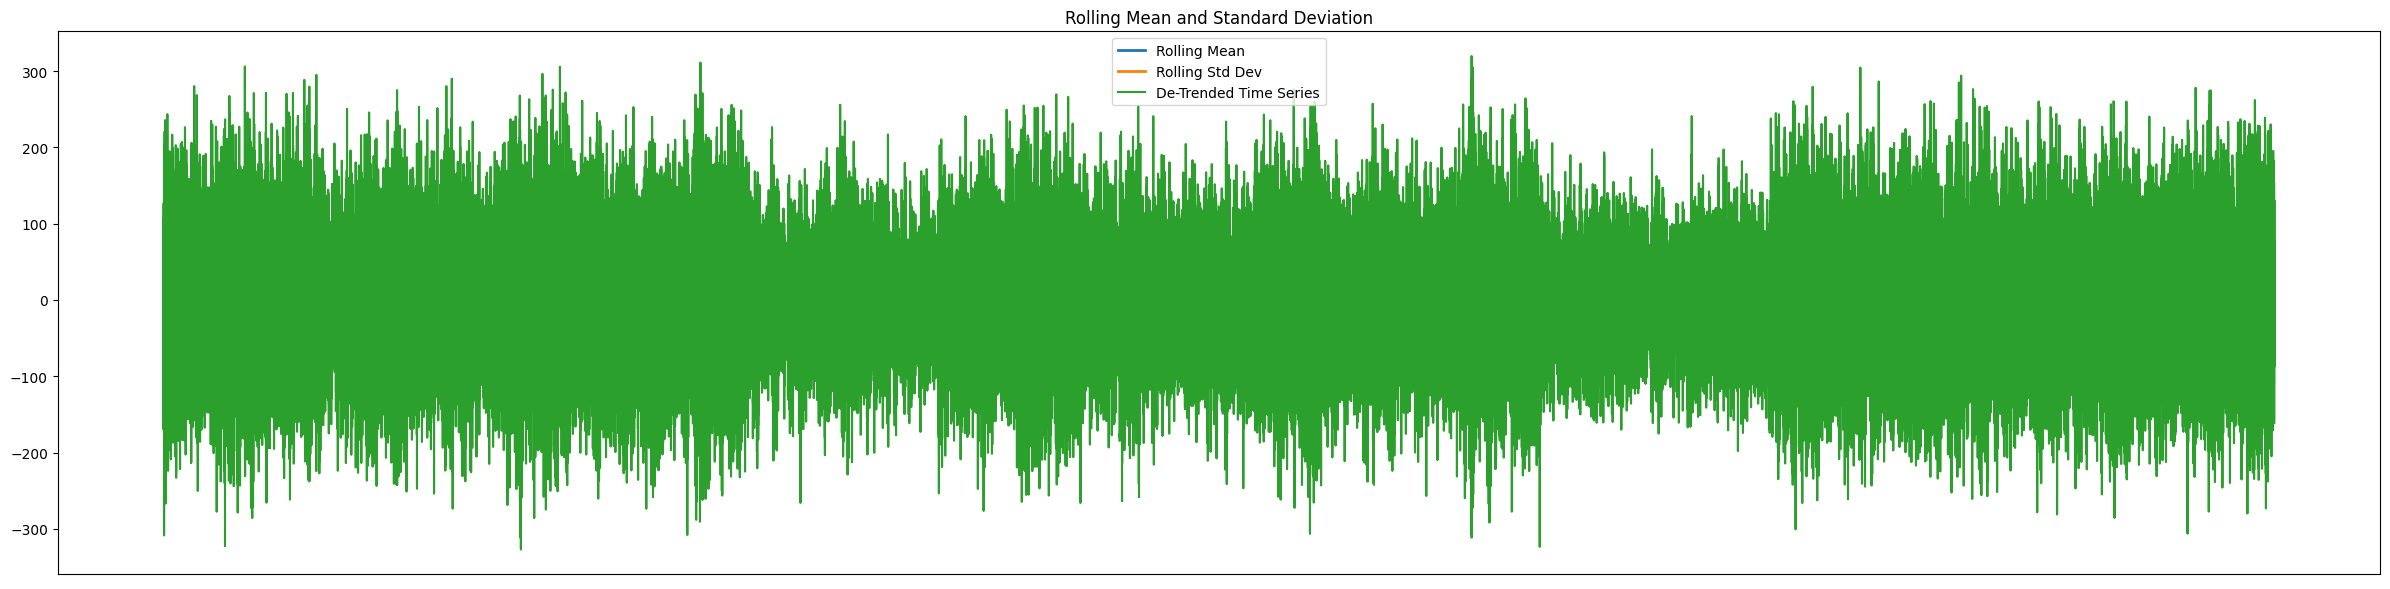

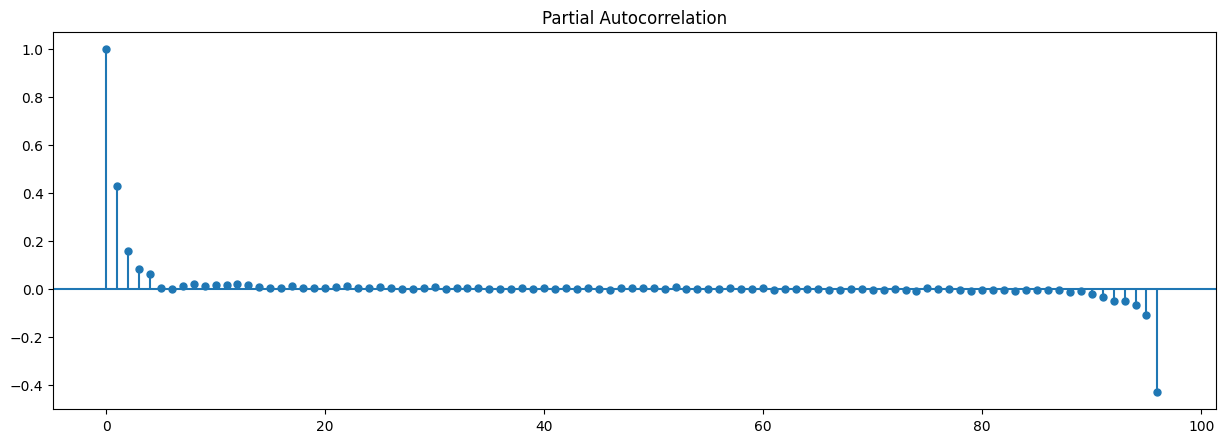

In [49]:
# Test for stationarity after de-trending 
def stationarity_test(rebap_eur_mwh):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = rebap_eur_mwh.rolling(96).mean()
    rolling_std_dev = rebap_eur_mwh.rolling(96).std()
  
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(rebap_eur_mwh,label='De-Trended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(rebap_eur_mwh,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(rebap_eur_mwh, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_input['1_rebap_eur_mwh'])

# Partial Autocorrelation Plot
pacf = plot_pacf(df_input['1_rebap_eur_mwh'], lags=96)

# Split the Data

We will split our data and take the first part as our training set and the years after 2020 as a test set. Since we are dealing with a time series here we cannot split randomly as we are used to do. 

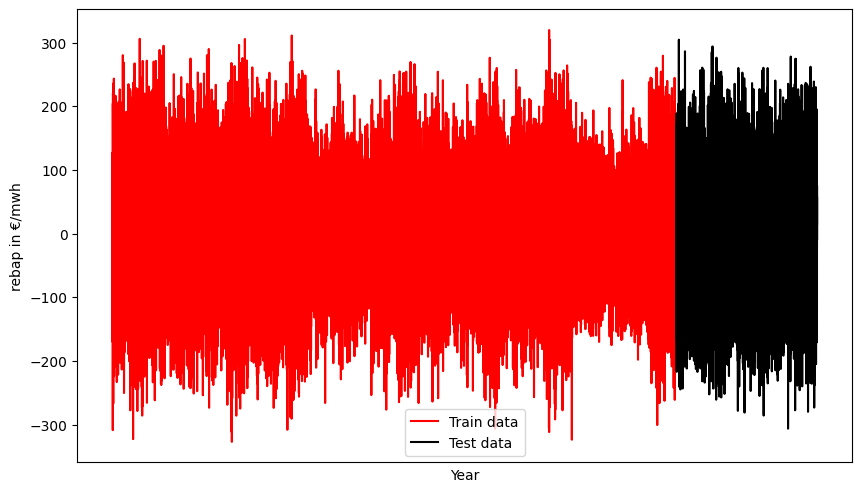

In [43]:
# Split data into train and test set
df_arima = df_input['1_rebap_eur_mwh']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('rebap in €/mwh')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

In [44]:
# NAN Check of the input_df:
df_input.isna().sum()

timestamp          0
1_rebap_eur_mwh    0
dtype: int64

In [45]:
df_input['1_rebap_eur_mwh'].describe()

count    251097.000000
mean          0.032941
std          60.453015
min        -327.010000
25%         -32.610000
50%          -0.030000
75%          32.540000
max         319.760000
Name: 1_rebap_eur_mwh, dtype: float64

### Simple Exponential Smoothing (Text from neuefische Notebook 02_Time_Series_Stock_Price

Simple Exponential Smoothing (SES) is used when the data doesn't contain any trend or seasonality. Smoothing Factor for level ($\alpha$) provides weightage to the influence of the observations. With larger values of $\alpha$ more attention is given to the most recent past observations whereas smaller values indicate that more past observations are being considered for forecasting. 

$$F_{t+1} = \alpha d_t + (1 - \alpha)F_t$$

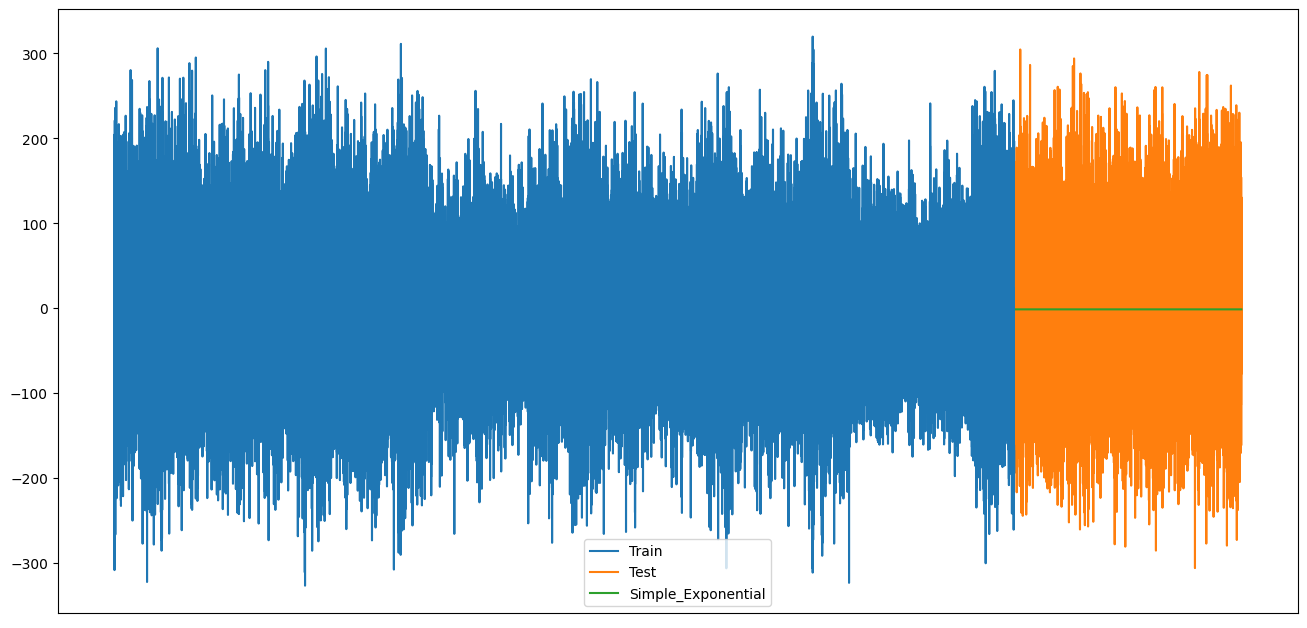

Simple Exponential Smoothing RMS :- 65.778 & Smoothing Level :- 0.323


In [46]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.01,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

# Holt´s Exponential Smoothing Method

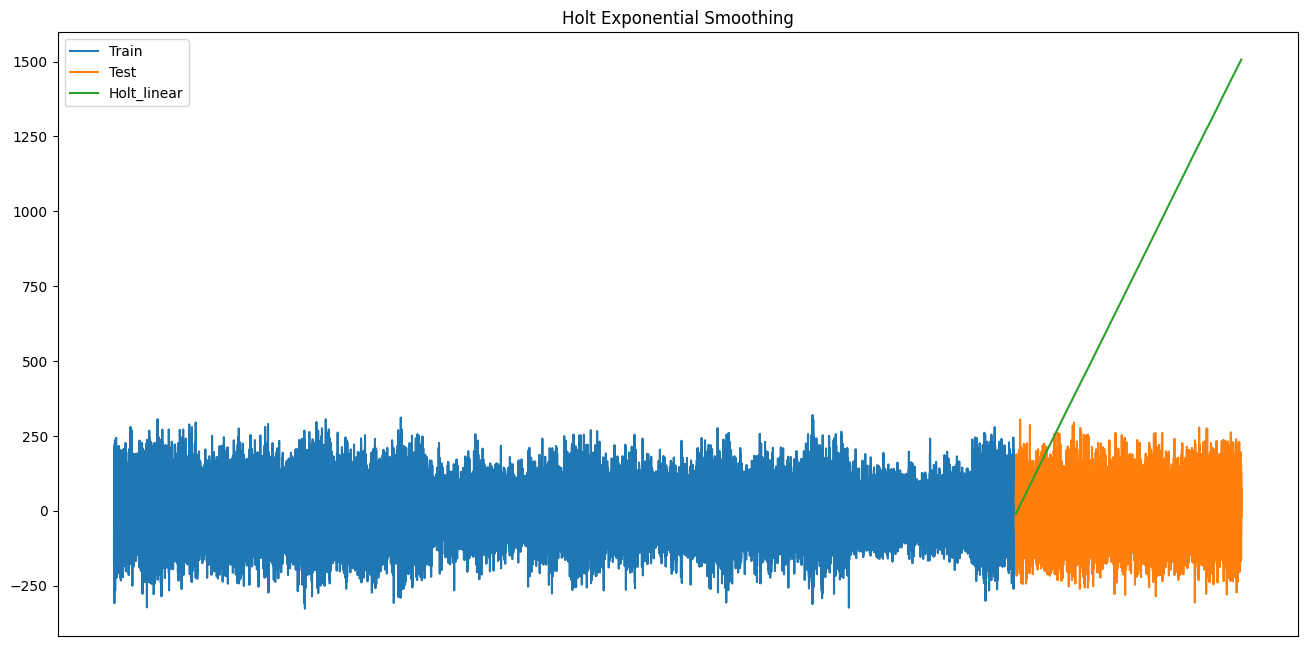

Holt’s Exponential Smoothing RMS :- 869.416 & Smoothing Level :- 0.218 & Smoothing Slope :- 0.01


In [47]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.01,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Holt´s Exponential Smoothing Method produces an obviously not-fitting linear approximation: Re-run it 1 time, with Alpha = 0.01.

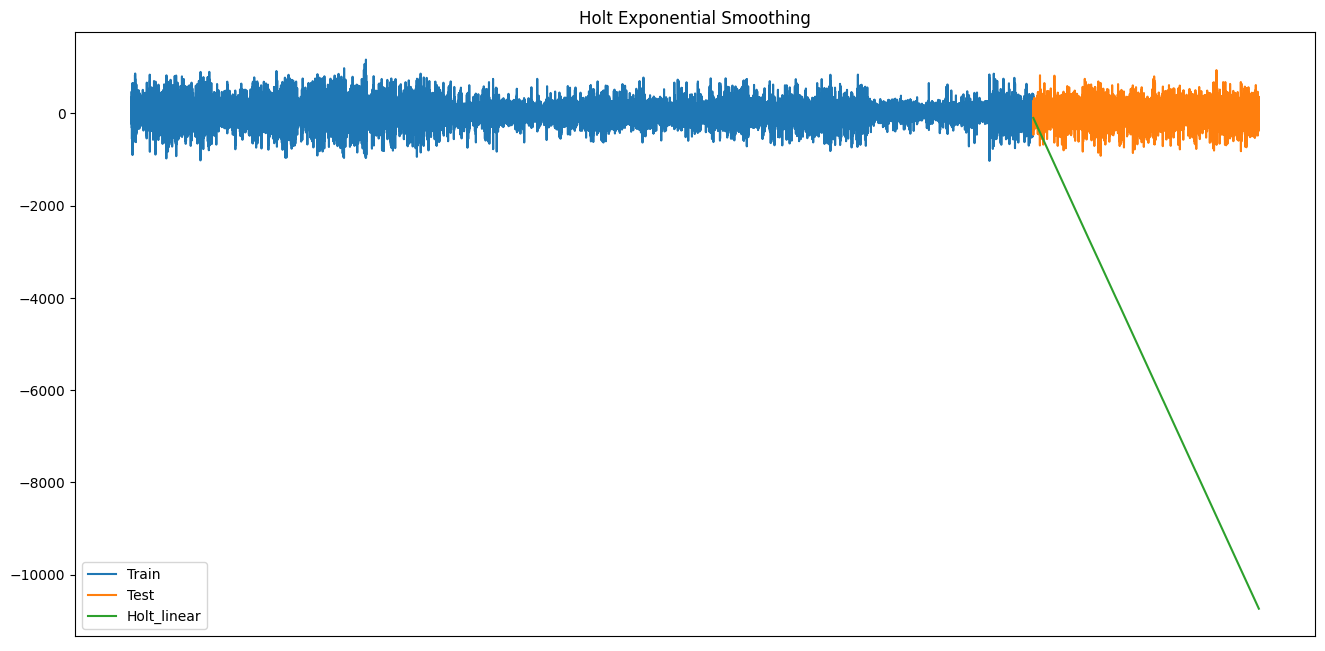

Holt’s Exponential Smoothing RMS :- 6230.002 & Smoothing Level :- 0.35 & Smoothing Slope :- 0.15


In [84]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

# ARIMA Model

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2160306.731, Time=11.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2208587.961, Time=1.43 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2168065.185, Time=2.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2179904.987, Time=7.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2160103.163, Time=9.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2162639.056, Time=3.57 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2160105.158, Time=30.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2160105.215, Time=22.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2160104.998, Time=10.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2160945.577, Time=4.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2160101.920, Time=15.68 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2160050.347, Time=19.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2160061.548, Time=29.26 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2159640.454

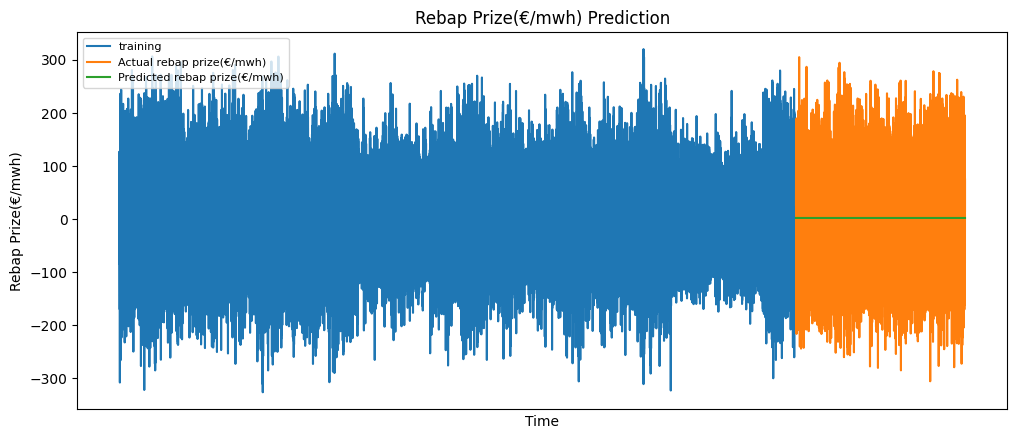

Auto-Arima RMSE :- 65.774


In [48]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.01,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual rebap prize(€/mwh)')
plt.plot(fcv_series,label='Predicted rebap prize(€/mwh)')
plt.title('Rebap Prize(€/mwh) Prediction')
plt.xlabel('Time')
plt.ylabel('Rebap Prize(€/mwh)')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

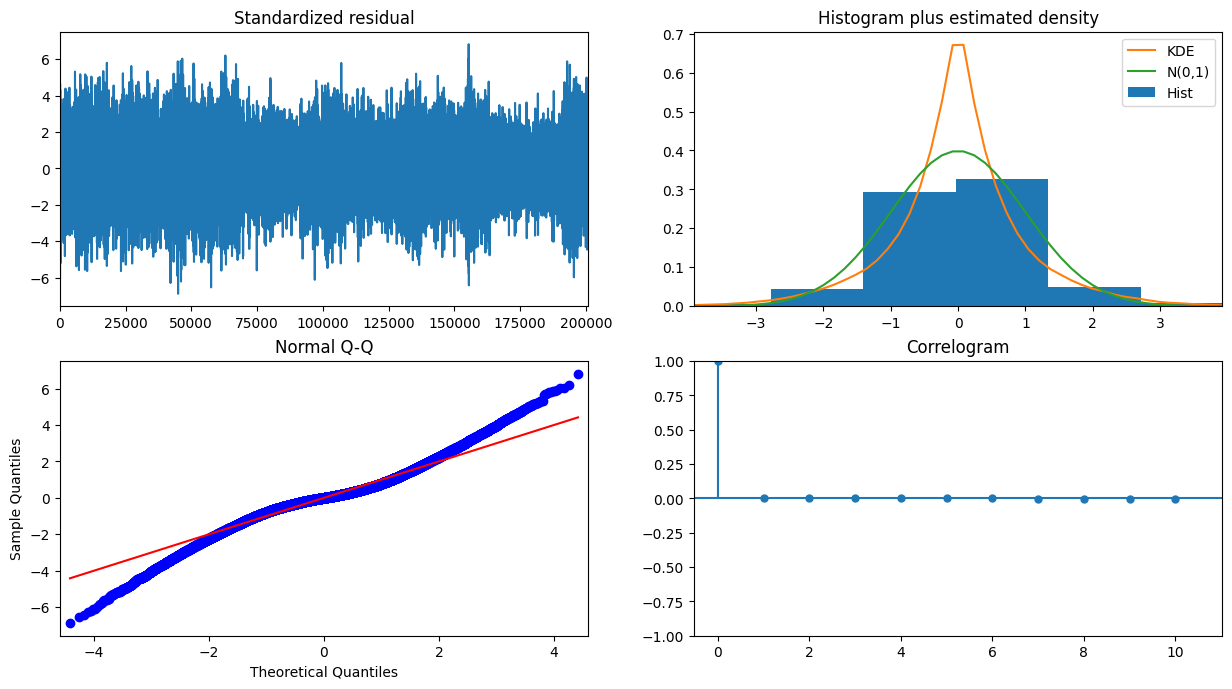

In [50]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

## Evaluation of the Models

To evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best (alpha = 0.05).

In [123]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  114.758
Simple Exponential Smoothing:  78.515
Holt’s Exponential Smoothing:  6230.002


From the three quite poorly performing model, the Simple Exponential Smoothing Method worked best.

Model performance with alpha = 0.01:

In [51]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  65.774
Simple Exponential Smoothing:  65.778
Holt’s Exponential Smoothing:  869.416


Even with alpha= 0.01 (more of the older data points are being considered in the calculation), there is only the Simple Exponential Smoothing Method showing a little bit of improvement, the others got worse (Holt) or didn´t change(Auto-Arima).